# Stability of results wrt random seeds

In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=3
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import umap
from firelight.visualizers.colorization import get_distinct_colors
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
import pickle
import matplotlib
from umap.my_utils import compute_loss_table, get_ring, compute_low_dim_psims
from umap.my_plot import cut_y_axis, get_mean_std_dev_losses
from scipy.sparse import coo_matrix

env: CUDA_VISIBLE_DEVICES=3


In [2]:
repeats = 7
data_path_c_elegans = "../data/packer_c-elegans"
data_path_ring = "../data/toy_ring"
data_path_cifar = "../data/cifar10"
data_path_lung_cancer = "../data/zilionis_cancer"
data_path_pbmc = "../data/zheng_pbmc/"
fig_path = "../figures"

loss_methods = ["actual", "effective", "purported"]
loss_types = ["attractive", "repulsive", "total"]

# C. elegans experiments

In [3]:
# read meta data, obtain colors and ordering of cells that puts special_cell_type to the front and unlabelled cells to
# the back
special_cell_type = "Seam_cell"
meta = pd.read_csv(os.path.join(data_path_c_elegans,
                              "c-elegans_qc_final_metadata.txt"),
                   sep=',',
                   header=0)

cell_types = meta["cell.type"].to_numpy().astype(str)

labels = np.zeros(len(cell_types)).astype(int)
name_to_label = {}
for i, phase in enumerate(np.unique(cell_types)):
    name_to_label[phase] = i
    labels[cell_types==phase] = i

special_cell_label = name_to_label[special_cell_type]
unnamed_label = name_to_label["nan"]

np.random.seed(0)
colors = get_distinct_colors(len(name_to_label))
np.random.shuffle(colors)
colors[special_cell_label] = [0,0,0]
colors[unnamed_label] = [0.5, 0.5, 0.5]
cmap = ListedColormap(colors)

special_order1 = np.argsort(labels == special_cell_label, kind="stable") # put idx of special label to the back
special_order2 = np.argsort(labels[special_order1] != unnamed_label, kind="stable") # put idx of unnamed label to the front
special_order = special_order1[special_order2]
special_order_no_nan = special_order[(labels==unnamed_label).sum():]

In [4]:
# load C. elegans data
pca100 = pd.read_csv(os.path.join(data_path_c_elegans,
                              "c-elegans_qc_final.txt"),
                 sep='\t',
                 header=None)
pca100.shape


(86024, 100)

## Compute loss after full epoch
### Original UMAP

In [5]:
# can take long, approx repeats * 30 min
umappers_c_elegans_after = []
for repeat in range(repeats):
    try:
        with open(os.path.join(data_path_c_elegans, f"umapperns_after_seed_{repeat}.pkl"), "rb") as file:
            umapper = pickle.load((file))
    except FileNotFoundError:
        umapper= umap.UMAP(metric="cosine",
                             n_neighbors=30,
                             n_epochs=750,
                             log_losses="after",
                             log_samples=False,
                             random_state=repeat,
                             verbose=True)
        _ = umapper.fit_transform(pca100)
        with open(os.path.join(data_path_c_elegans, f"umapperns_after_seed_{repeat}.pkl"), "wb") as file:
            pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)
    umappers_c_elegans_after.append(umapper)
    print(f"done with run {repeat}")

Wed Oct 27 13:10:24 2021 Building and compiling search function
done with run 0
Wed Oct 27 13:10:27 2021 Building and compiling search function
done with run 1
Wed Oct 27 13:10:30 2021 Building and compiling search function
done with run 2
Wed Oct 27 13:10:32 2021 Building and compiling search function
done with run 3
Wed Oct 27 13:10:33 2021 Building and compiling search function
done with run 4
Wed Oct 27 13:10:35 2021 Building and compiling search function
done with run 5
Wed Oct 27 13:10:36 2021 Building and compiling search function
done with run 6


In [6]:
# compute mean and std of losses over different runs
mean_losses, std_losses = get_mean_std_dev_losses(umappers_c_elegans_after)

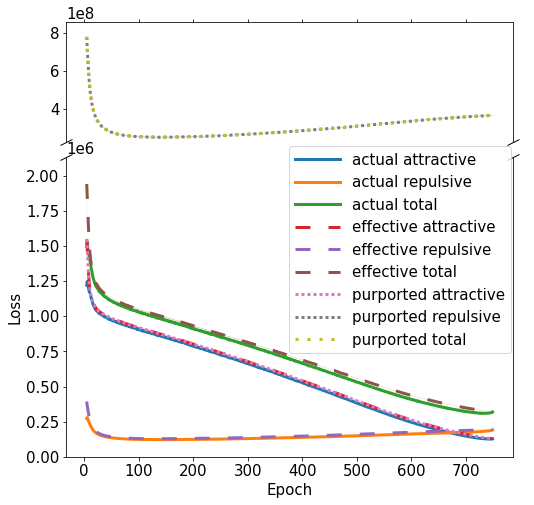

In [7]:
# plot mean loss curves with std dev
start = 5
matplotlib.rcParams.update({'font.size': 15})
fig1 = cut_y_axis(mean_losses,
           loss_methods,
           loss_types,
           std_losses,
           start=start)
fig1.savefig(os.path.join(fig_path, f"c_elegans_after_losses_std_1.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

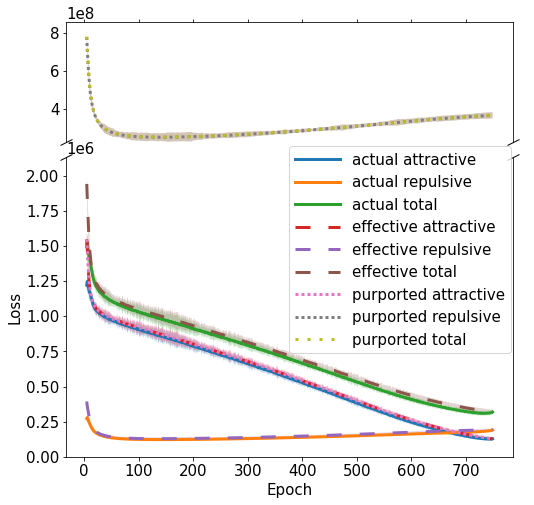

In [8]:
# plot mean loss curves with exaggerated std dev
matplotlib.rcParams.update({'font.size': 15})
fig10 = cut_y_axis(mean_losses,
           loss_methods,
           loss_types,
           10 * np.array(std_losses),
           start=start)
fig10.savefig(os.path.join(fig_path, f"c_elegans_after_losses_std_10.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

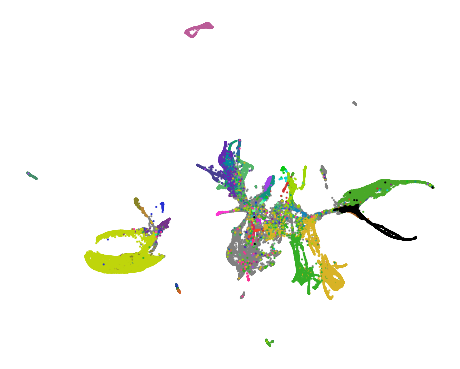

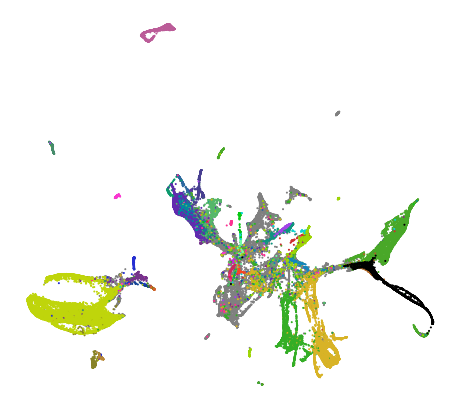

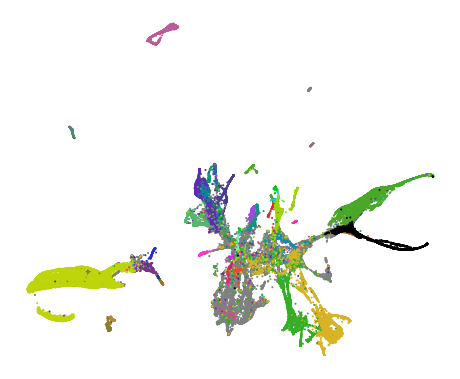

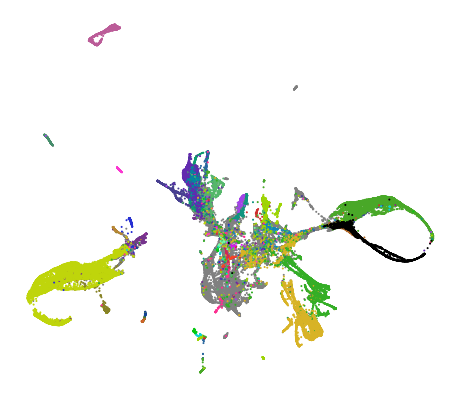

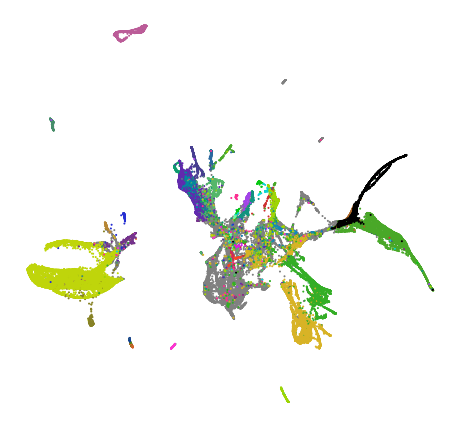

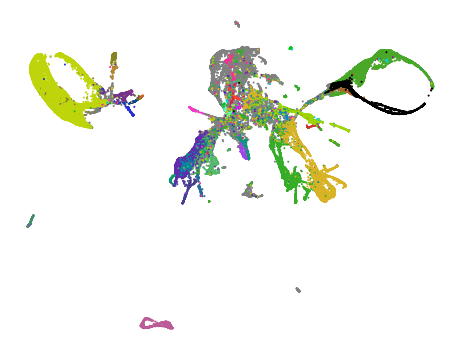

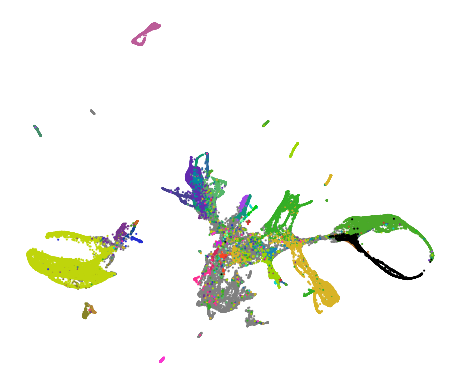

In [9]:
# plot and save embeddings of different runs
plt.figure(figsize=(8,8))
scatter = plt.scatter(- umappers_c_elegans_after[0].embedding_[special_order].T[1],
                      - umappers_c_elegans_after[0].embedding_[special_order].T[0],
                      c=labels[special_order],
                      s=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_after_seed_0.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)


plt.figure(figsize=(8,8))
scatter = plt.scatter(umappers_c_elegans_after[1].embedding_[special_order].T[1],
                      umappers_c_elegans_after[1].embedding_[special_order].T[0],
                      c=labels[special_order],
                      s=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_after_seed_1.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

plt.figure(figsize=(8,8))
scatter = plt.scatter(umappers_c_elegans_after[2].embedding_[special_order].T[1],
                      umappers_c_elegans_after[2].embedding_[special_order].T[0],
                      c=labels[special_order],
                      s=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_after_seed_2.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

plt.figure(figsize=(8,8))
scatter = plt.scatter(umappers_c_elegans_after[3].embedding_[special_order].T[1],
                      umappers_c_elegans_after[3].embedding_[special_order].T[0],
                      c=labels[special_order],
                      s=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_after_seed_3.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

plt.figure(figsize=(8,8))
scatter = plt.scatter(- umappers_c_elegans_after[4].embedding_[special_order].T[1],
                      - umappers_c_elegans_after[4].embedding_[special_order].T[0],
                      c=labels[special_order],
                      s=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_after_seed_4.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

plt.figure(figsize=(8,8))
scatter = plt.scatter(umappers_c_elegans_after[5].embedding_[special_order].T[1],
                      - umappers_c_elegans_after[5].embedding_[special_order].T[0],
                      c=labels[special_order],
                      s=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_after_seed_5.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

plt.figure(figsize=(8,8))
scatter = plt.scatter(- umappers_c_elegans_after[6].embedding_[special_order].T[1],
                      - umappers_c_elegans_after[6].embedding_[special_order].T[0],
                      c=labels[special_order],
                      s=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path, f"c_elegans_after_seed_6.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

### Inverted UMAP

In [10]:
# get inverted similarities
inv_graphs = []
assert "umappers_c_elegans_after" in locals()
for umapper in umappers_c_elegans_after:
    inv_graph = umapper.graph_.copy()
    inv_graph.data[inv_graph.data < inv_graph.data.max() / float(750)] = 0
    inv_graph.eliminate_zeros()
    inv_graph.data = inv_graph.data.min() / inv_graph.data
    inv_graphs.append(inv_graph)

In [11]:
umappers_c_elegans_inv_after = []
for i, repeat in enumerate(range(repeats)):
    try:
        with open(os.path.join(data_path_c_elegans, f"umapperns_inv_seed_{repeat}.pkl"), "rb") as file:
            umapper = pickle.load((file))
    except FileNotFoundError:
        umapper= umap.UMAP(metric="cosine",
                             n_neighbors=30,
                             n_epochs=750,
                             log_losses="after",
                             graph=inv_graphs[i],
                             log_samples=False,
                             random_state=repeat,
                             verbose=True)
        _ = umapper.fit_transform(pca100)
        with open(os.path.join(data_path_c_elegans, f"umapperns_inv_seed_{repeat}.pkl"), "wb") as file:
            pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)
    umappers_c_elegans_inv_after.append(umapper)
    print(f"done with run {repeat}")

done with run 0
done with run 1
done with run 2
done with run 3
done with run 4
done with run 5
done with run 6


## Loss during epoch

In [12]:
# compute UMAP instances for various random seeds
# can take long, approx repeats * 30 min
umappers_c_elegans_during = []

for repeat in range(repeats):
    try:
        with open(os.path.join(data_path_c_elegans, f"umapperns_during_seed_{repeat}.pkl"), "rb") as file:
            umapper = pickle.load((file))
    except FileNotFoundError:
        umapper= umap.UMAP(metric="cosine",
                             n_neighbors=30,
                             n_epochs=750,
                             log_losses="during",
                             log_samples=False,
                             random_state=repeat,
                             verbose=True)
        _ = umapper.fit_transform(pca100)
        with open(os.path.join(data_path_c_elegans, f"umapperns_during_seed_{repeat}.pkl"), "wb") as file:
            pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)
    umappers_c_elegans_during.append(umapper)
    print(f"done with run {repeat}")

Wed Oct 27 13:11:13 2021 Building and compiling search function
done with run 0
Wed Oct 27 13:11:14 2021 Building and compiling search function
done with run 1
Wed Oct 27 13:11:16 2021 Building and compiling search function
done with run 2
Wed Oct 27 13:11:18 2021 Building and compiling search function
done with run 3
Wed Oct 27 13:11:19 2021 Building and compiling search function
done with run 4
Wed Oct 27 13:11:21 2021 Building and compiling search function
done with run 5
Wed Oct 27 13:11:22 2021 Building and compiling search function
done with run 6


In [13]:
# compute mean and std of losses over different runs
mean_losses, std_losses = get_mean_std_dev_losses(umappers_c_elegans_during)


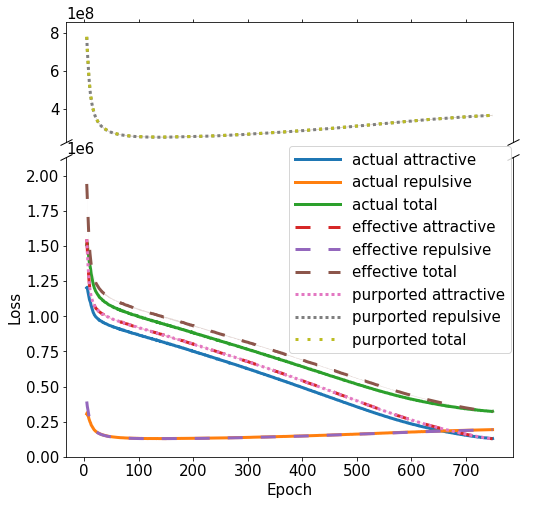

In [14]:
# plot mean losses and std dev
start = 5
matplotlib.rcParams.update({'font.size': 15})
fig1 = cut_y_axis(mean_losses,
           loss_methods,
           loss_types,
           np.array(std_losses),
           start=start)
fig1.savefig(os.path.join(fig_path, f"c_elegans_during_losses_std_1.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

# Toy ring

## Use random seed both for resampling the data and for the UMAP instance

In [15]:
# compute UMAP instances for various random seeds
umappers_init_10000_resample_data = []
data_samples = []

for repeat in range(repeats):
    try:
        data = np.load(os.path.join(data_path_ring, f"toy_ring_1000_4_0_5_original_seed_{repeat}.npy"))
    except FileNotFoundError:
        np.random.seed(repeat)
        data = get_ring(1000, 4, 0.5, noise="uniform")  # n=7000, r = 4, var = 0.5 yiels crisp circle for n_epochs=10000
        np.save(os.path.join(data_path_ring,
                             f"toy_ring_1000_4_0_5_original_seed_{repeat}.npy"),
                data)

    try:
        with open(os.path.join(data_path_ring, f"toy_ring_1000_4_0_5_umapperns_init_10000_seed_{repeat}_{repeat}.pkl"), "rb") as file:
            umapper = pickle.load(file)
    except FileNotFoundError:
        umapper = umap.UMAP(
            random_state=repeat,
            init=data,
            n_epochs=10000,
            verbose=True)
        _ = umapper.fit_transform(data)
        with open(os.path.join(data_path_ring, f"toy_ring_1000_4_0_5_umapperns_init_10000_seed_{repeat}_{repeat}.pkl"), "wb") as file:
            pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)
    umappers_init_10000_resample_data.append(umapper)
    data_samples.append(data)
    print(f"done with run {repeat}")


done with run 0
done with run 1
done with run 2
done with run 3
done with run 4
done with run 5
done with run 6


In [16]:
losses_init_10000_resample_data = []
for umapper, data in zip(umappers_init_10000_resample_data, data_samples):
    losses_init_10000_resample_data.append(compute_loss_table(umapper, data))

In [17]:
# turn list of dicts into dict of lists and select only the total loss
losses_init_10000_resample_data = {k: [dic[k][-1] for dic in losses_init_10000_resample_data] for k in losses_init_10000_resample_data[0]}

In [18]:
mean_losses_init_10000_resample_data = {k: np.array(losses_init_10000_resample_data[k]).mean() for k in losses_init_10000_resample_data.keys() }
std_losses_init_10000_resample_data = {k: np.array(losses_init_10000_resample_data[k]).std() for k in losses_init_10000_resample_data.keys() }

In [19]:
print(mean_losses_init_10000_resample_data)
print(std_losses_init_10000_resample_data)

{'loss_high_high': 6913.633131981008, 'loss_high_0': 62959.03523399779, 'loss_high_low_embd': 70235.1841686147, 'loss_high_low_data': 136329.36182897392, 'eff_loss_target': 1523.1673860738597, 'eff_loss_0': 54017.438334645805, 'eff_loss_low_embd': 3388.1883235283617, 'eff_loss_low_data': 4972.791281803703}
{'loss_high_high': 41.46370670289876, 'loss_high_0': 81.88353232605073, 'loss_high_low_embd': 1300.731025064961, 'loss_high_low_data': 720.8968344462679, 'eff_loss_target': 6.655435110570669, 'eff_loss_0': 82.29294972648631, 'eff_loss_low_embd': 23.448527446666453, 'eff_loss_low_data': 27.833160452279536}


### Dense input similarities

In [20]:
# get parameters a, b
min_dist = 0.1
spread = 1.0
a, b= umap.umap_.find_ab_params(spread=spread, min_dist=min_dist)

In [21]:
# compute UMAP instances for several random seeds
umappers_init_graph_10000_resample_data = []

for repeat in range(repeats):
    try:
        data = np.load(os.path.join(data_path_ring, f"toy_ring_1000_4_0_5_original_seed_{repeat}.npy"))
    except FileNotFoundError:
        np.random.seed(repeat)
        data = get_ring(1000, 4, 0.5, noise="uniform")
        np.save(os.path.join(data_path_ring,
                             f"toy_ring_1000_4_0_5_original_seed_{repeat}.npy"),
                data)
    try:
        with open(os.path.join(data_path_ring, f"toy_ring_1000_4_0_5_umapperns_init_graph_10000_seed_{repeat}_{repeat}.pkl"), "rb") as file:
            umapper = pickle.load(file)
    except FileNotFoundError:
        low_sim_sparse = coo_matrix(compute_low_dim_psims(data, a, b))
        umapper = umap.UMAP(
            graph=low_sim_sparse,
            random_state=repeat,
            init=data,
            n_epochs=10000,
            verbose=True)
        _ = umapper.fit_transform(data)
        with open(os.path.join(data_path_ring, f"toy_ring_1000_4_0_5_umapperns_init_graph_10000_seed_{repeat}_{repeat}.pkl"), "wb") as file:
            pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)
    umappers_init_graph_10000_resample_data.append(umapper)
    print(f"done with run {repeat}")

In [ ]:
# compute all losses
losses_init_graph_10000_resample_data = []
for umapper in umappers_init_graph_10000_resample_data:
    losses_init_graph_10000_resample_data.append(compute_loss_table(umapper, data))

# turn list of dicts into dict of lists and select only the total loss
losses_init_graph_10000_resample_data = {k: [dic[k][-1] for dic in losses_init_graph_10000_resample_data] for k in losses_init_graph_10000_resample_data[0]}

In [ ]:
mean_losses_init_graph_10000_resample_data = {k: np.array(losses_init_graph_10000_resample_data[k]).mean() for k in losses_init_graph_10000_resample_data.keys() }
std_losses_init_graph_10000_resample_data = {k: np.array(losses_init_graph_10000_resample_data[k]).std() for k in losses_init_graph_10000_resample_data.keys() }

In [ ]:
print(mean_losses_init_graph_10000_resample_data)
print(std_losses_init_graph_10000_resample_data)

# CIFAR 10

In [22]:
#load the data
cifar10_resnet50 = np.load(os.path.join(data_path_cifar, "cifar10_resnet50_features.npy"))
cifar10_labels = np.load(os.path.join(data_path_cifar, "cifar10_labels.npy"))
with open(os.path.join(data_path_cifar, 'class_names')) as f:
    cifar10_class_names = f.readlines()
    cifar10_class_names = np.array([name.rstrip(",\n") for name in cifar10_class_names])

In [23]:
# compute UMAP instances for various random seeds
umappers_cifar = []
for repeat in range(repeats):
    try:
        with open(os.path.join(data_path_cifar, f"cifar_umapperns_after_seed_{repeat}.pkl"), "rb") as file:
            umapper = pickle.load(file)
    except FileNotFoundError:
        umapper = umap.UMAP(log_losses="after",
                              random_state=repeat,
                              verbose=True)
        _ = umapper.fit_transform(cifar10_resnet50)
        with open(os.path.join(data_path_cifar, f"cifar_umapperns_after_seed_{repeat}.pkl"), "wb") as file:
            pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)
    umappers_cifar.append(umapper)
    print(f"done with run {repeat}")


Wed Oct 27 13:13:16 2021 Building and compiling search function
done with run 0
Wed Oct 27 13:13:20 2021 Building and compiling search function
done with run 1
Wed Oct 27 13:13:23 2021 Building and compiling search function
done with run 2
Wed Oct 27 13:13:26 2021 Building and compiling search function
done with run 3
Wed Oct 27 13:13:28 2021 Building and compiling search function
done with run 4
Wed Oct 27 13:13:31 2021 Building and compiling search function
done with run 5
Wed Oct 27 13:13:34 2021 Building and compiling search function
done with run 6


In [24]:
# compute mean and std of losses over different runs
mean_losses, std_losses = get_mean_std_dev_losses(umappers_cifar)

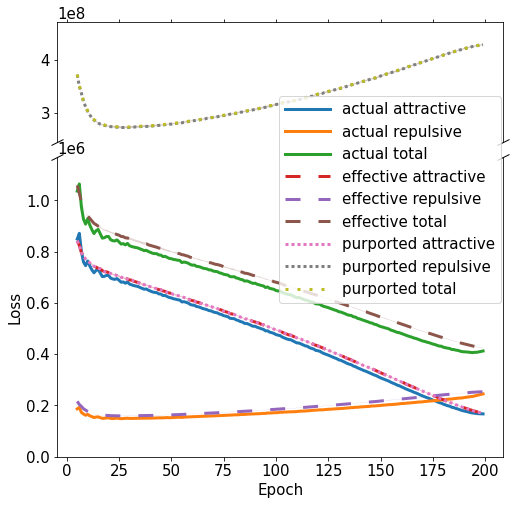

In [25]:
# plot mean losses and std dev
start = 5
matplotlib.rcParams.update({'font.size': 15})
fig1 = cut_y_axis(mean_losses,
           loss_methods,
           loss_types,
           np.array(std_losses),
           start=start,
           leg_loc=(0.535, 0.4))
fig1.savefig(os.path.join(fig_path, f"cifar_after_losses_std_1.png"),
            bbox_inches = 'tight',
            pad_inches = 0,dpi=300)

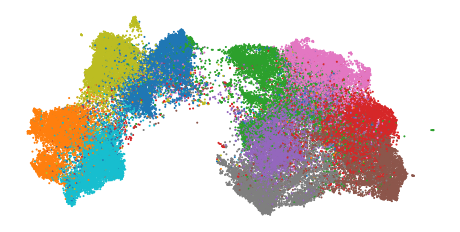

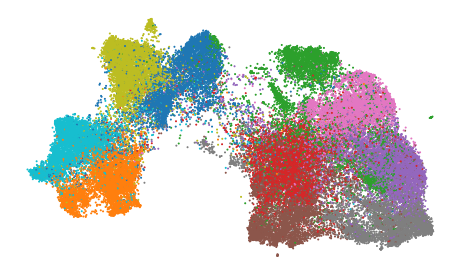

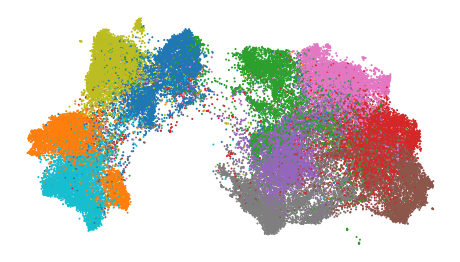

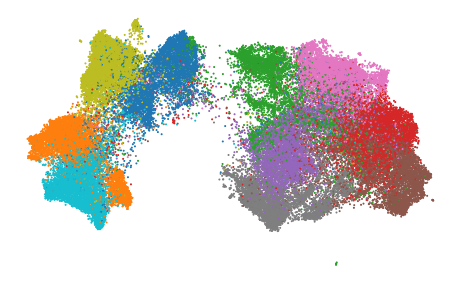

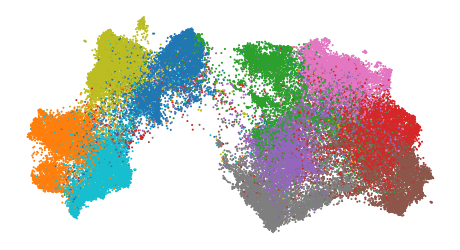

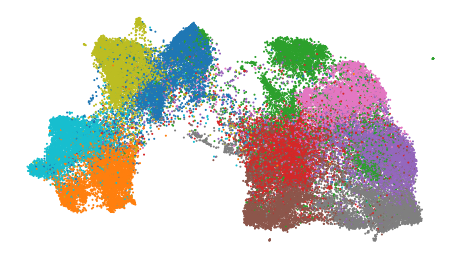

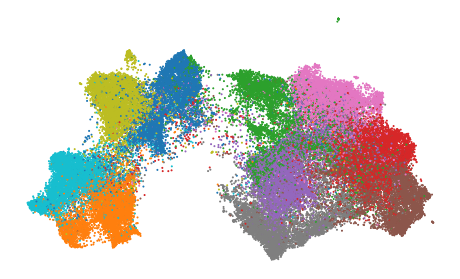

In [26]:
for i in range(repeats):
    plt.figure(figsize=(8,8))
    scatter = plt.scatter(*umappers_cifar[i].embedding_.T,
                          c=cifar10_labels,
                          s=1.0,
                          cmap="tab10")
    plt.axis("off")
    plt.gca().set_aspect("equal")

# Lung cancer



In [27]:
# load the data
pca306 = pd.read_csv(os.path.join(data_path_lung_cancer,
                                  "cancer_qc_final.txt"),
                     sep='\t',
                     header=None)
pca306.shape

(48969, 306)

In [28]:
meta = pd.read_csv(os.path.join(data_path_lung_cancer,
                              "cancer_qc_final_metadata.txt"),
                   sep="\t",
                   header=0)

cell_types = meta["Major cell type"].to_numpy()

cell_types = np.array([cell_type[1:] for cell_type in cell_types])

lung_cancer_labels = np.zeros(len(cell_types)).astype(int)
name_to_lung_cancer_label = {}
for i, phase in enumerate(np.unique(cell_types)):
    name_to_lung_cancer_label[phase] = i
    lung_cancer_labels[cell_types==phase] = i
np.random.seed(0)
lung_caner_colors = get_distinct_colors(len(name_to_lung_cancer_label))
lung_cancer_cmap = ListedColormap(lung_caner_colors)
np.random.shuffle(lung_caner_colors)

In [29]:
umappers_lung_cancer = []
for repeat in range(repeats):
    try:
        with open(os.path.join(data_path_lung_cancer,
                               f"umapperns_after_seed_{repeat}.pkl"),
                  "rb") as file:
            umapper = pickle.load(file)
    except FileNotFoundError:
        umapper = umap.UMAP(metric="cosine",
                                      n_neighbors=30,
                                      n_epochs=750,
                                      log_losses="after",
                                      random_state=repeat,
                                      verbose=True)
        _ = umapper.fit_transform(pca306)
        with open(os.path.join(data_path_lung_cancer,
                               f"umapperns_after_seed_{repeat}.pkl"), "wb") as file:
            pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)
    umappers_lung_cancer.append(umapper)
    print(f"Done with run {repeat}.")

Wed Oct 27 13:13:49 2021 Building and compiling search function
Done with run 0.
Wed Oct 27 13:13:52 2021 Building and compiling search function
Done with run 1.
Wed Oct 27 13:13:53 2021 Building and compiling search function
Done with run 2.
Wed Oct 27 13:13:55 2021 Building and compiling search function
Done with run 3.
Wed Oct 27 13:13:56 2021 Building and compiling search function
Done with run 4.
Wed Oct 27 13:13:58 2021 Building and compiling search function
Done with run 5.
Wed Oct 27 13:13:59 2021 Building and compiling search function
Done with run 6.


In [30]:
# compute mean and std of losses over different runs
mean_losses, std_losses = get_mean_std_dev_losses(umappers_lung_cancer)

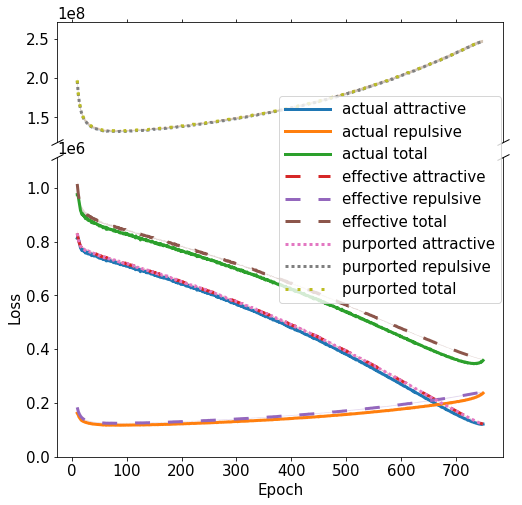

In [31]:
# plot mean losses and std dev
start = 10
matplotlib.rcParams.update({'font.size': 15})
fig1 = cut_y_axis(mean_losses,
           loss_methods,
           loss_types,
           np.array(std_losses),
           start=start,
           leg_loc=(0.535, 0.4))
fig1.savefig(os.path.join(fig_path, f"lung_cancer_after_losses_std_1.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
             dpi=300)

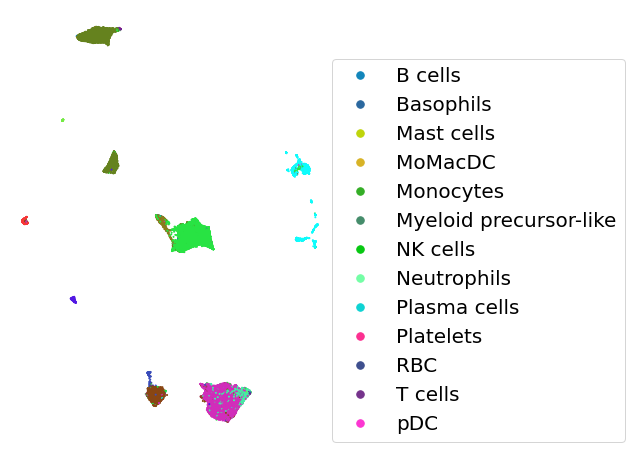

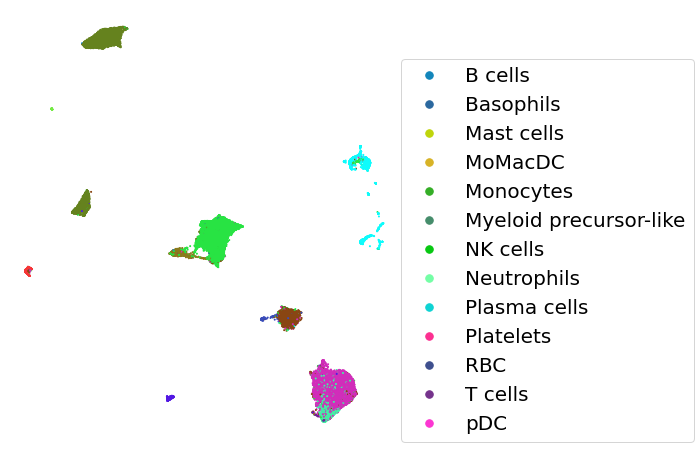

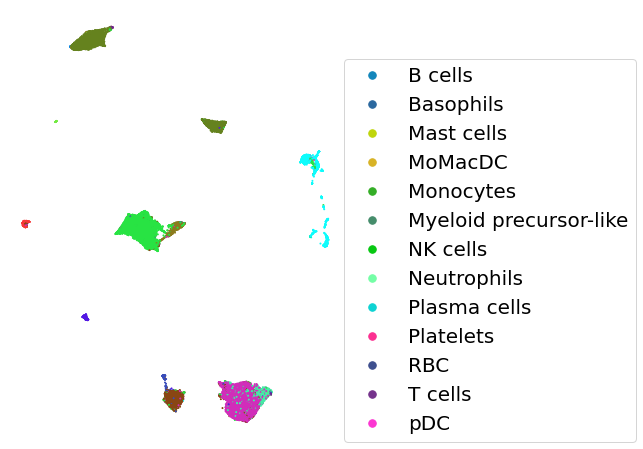

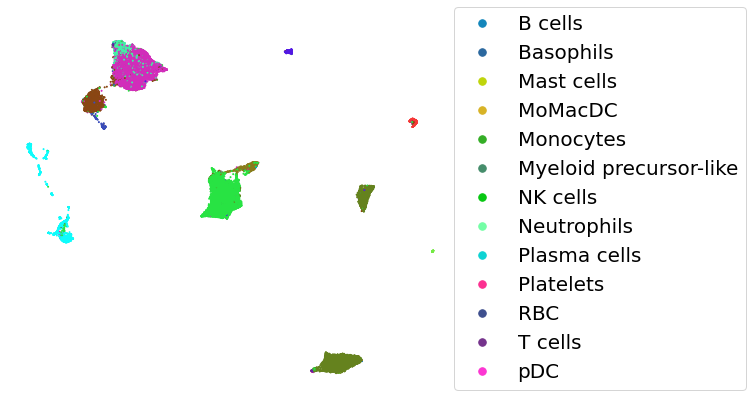

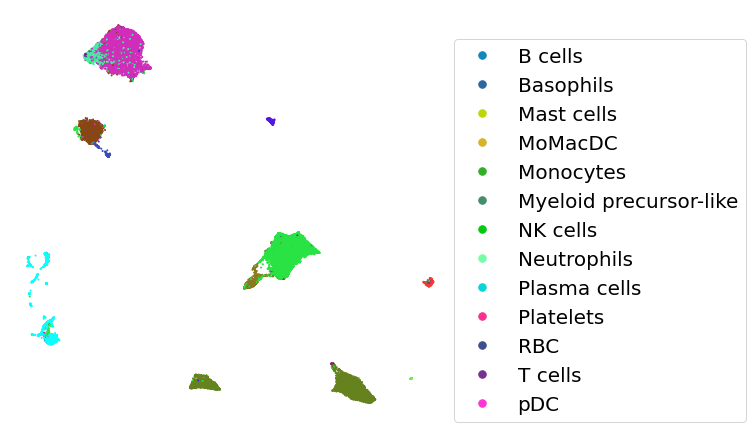

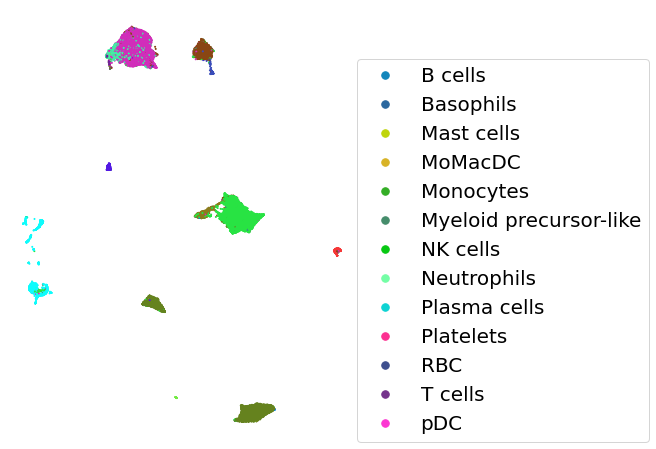

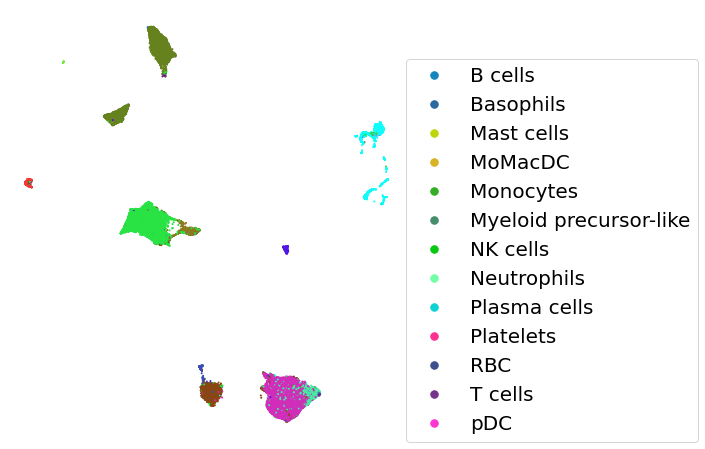

In [32]:
for i in range(repeats):
    plt.figure(figsize=(8,8))
    scatter = plt.scatter(*umappers_lung_cancer[i].embedding_.T,
                          c=lung_cancer_labels,
                          s=1.0,
                          cmap=lung_cancer_cmap)
    # dummy dots for legend
    dots = []
    for i in range(len(np.unique(cell_types))):
        dot = mlines.Line2D([], [], color=colors[i], marker='.', linestyle="none",
                              markersize=15, label=np.unique(cell_types)[i])
        dots.append(dot)
    plt.legend(handles=dots, prop={'size': 20}, loc=(1,0))

    plt.axis("off")
    plt.gca().set_aspect("equal")


# PBMC

In [33]:
# load the data
pca50 = pd.read_csv(os.path.join(data_path_pbmc,
                              "pbmc_qc_final.txt"),
                     sep='\t',
                     header=None)
pca50.shape

(68551, 50)

In [34]:
cell_types = pd.read_csv(os.path.join(data_path_pbmc,
                              "pbmc_qc_final_labels.txt"),
                   sep=',',
                   header=None).to_numpy().flatten()
np.unique(cell_types)

# rename cell types by stripping "CD..." prefixes if possible
for i in range(len(cell_types)):
    words = cell_types[i].split(" ")
    if words[0].startswith("CD") and not len(words) == 1:
        words = words[1:]
    cell_types[i] = " ".join(words)

pbmc_labels = np.zeros(len(cell_types)).astype(int)
name_to_pbmc_label = {}
for i, phase in enumerate(np.unique(cell_types)):
    name_to_pbmc_label[phase] = i
    pbmc_labels[cell_types==phase] = i
np.random.seed(0)
pbmc_colors = get_distinct_colors(len(name_to_pbmc_label))
pbmc_cmap = ListedColormap(pbmc_colors)
np.random.shuffle(pbmc_colors)


In [35]:
umappers_pbmc = []
for repeat in range(repeats):
    try:
        with open(os.path.join(data_path_pbmc,
                               f"umapperns_after_seed_{repeat}.pkl"), "rb") as file:
            umapper = pickle.load(file)
    except FileNotFoundError:
        umapper = umap.UMAP(metric="cosine",
                              n_neighbors=30,
                              n_epochs=750,
                              log_losses="after",
                              random_state=repeat,
                              verbose=True)
        _ = umapper.fit_transform(pca50)
        with open(os.path.join(data_path_pbmc,
                               f"umapperns_after_seed_{repeat}.pkl"), "wb") as file:
            pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)
    umappers_pbmc.append(umapper)
    print(f"Done with run {repeat}.")

Wed Oct 27 13:14:14 2021 Building and compiling search function
Done with run 0.
Wed Oct 27 13:14:16 2021 Building and compiling search function
Done with run 1.
Wed Oct 27 13:14:17 2021 Building and compiling search function
Done with run 2.
Wed Oct 27 13:14:19 2021 Building and compiling search function
Done with run 3.
Wed Oct 27 13:14:20 2021 Building and compiling search function
Done with run 4.
Wed Oct 27 13:14:22 2021 Building and compiling search function
Done with run 5.
Wed Oct 27 13:14:23 2021 Building and compiling search function
Done with run 6.


In [36]:
# compute mean and std of losses over different runs
mean_losses, std_losses = get_mean_std_dev_losses(umappers_pbmc)

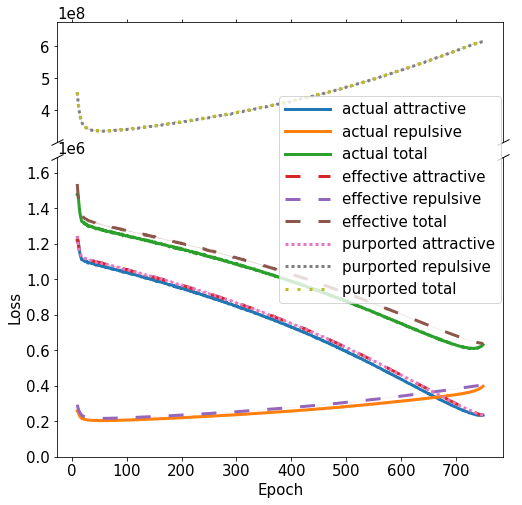

In [37]:
# plot mean losses and std dev
start = 10
matplotlib.rcParams.update({'font.size': 15})
fig1 = cut_y_axis(mean_losses,
           loss_methods,
           loss_types,
           np.array(std_losses),
           start=start,
           leg_loc=(0.535, 0.4))
fig1.savefig(os.path.join(fig_path, f"pbmc_after_losses_std_1.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
             dpi=300)

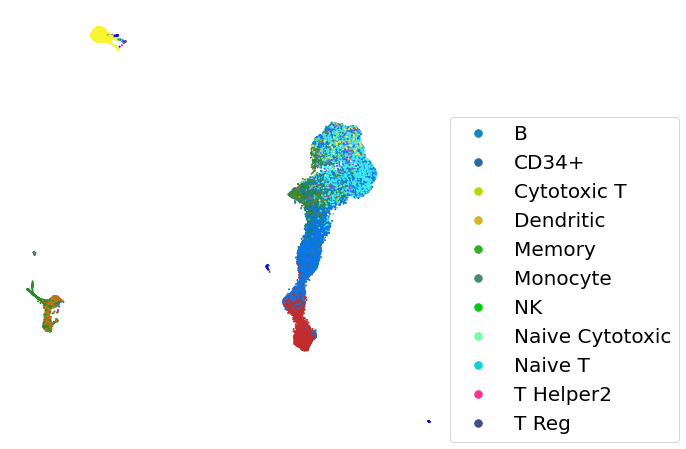

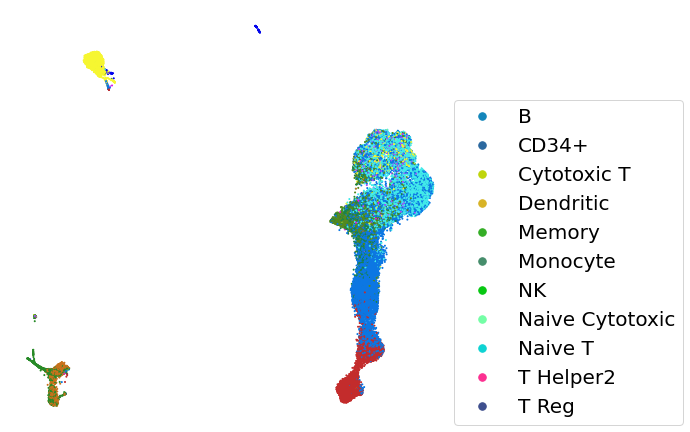

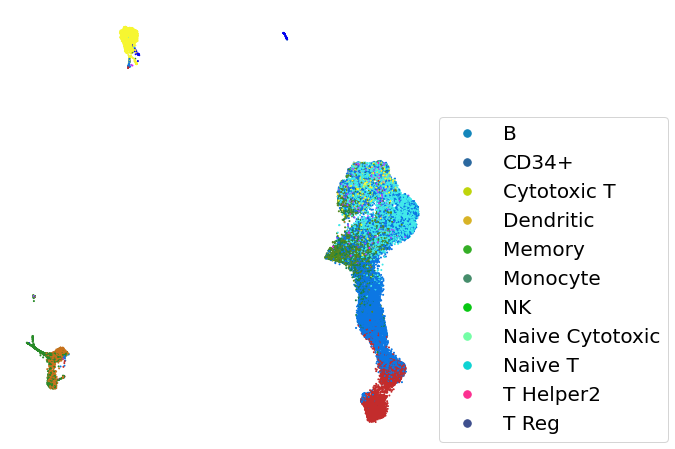

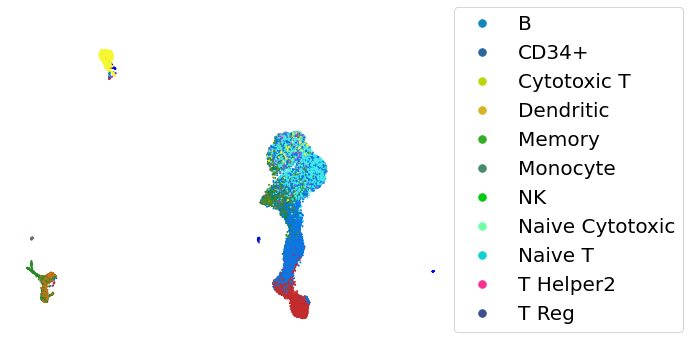

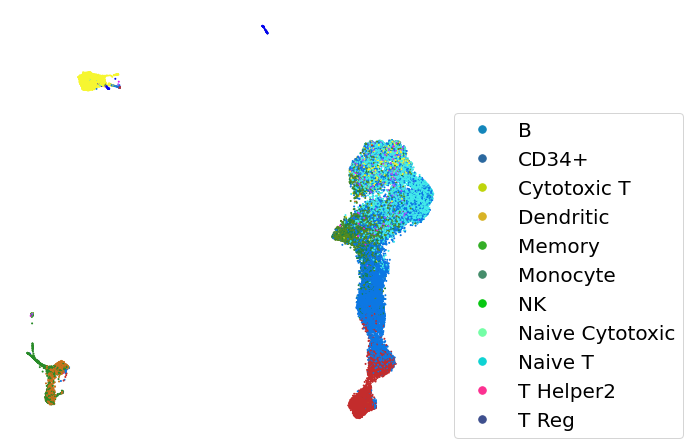

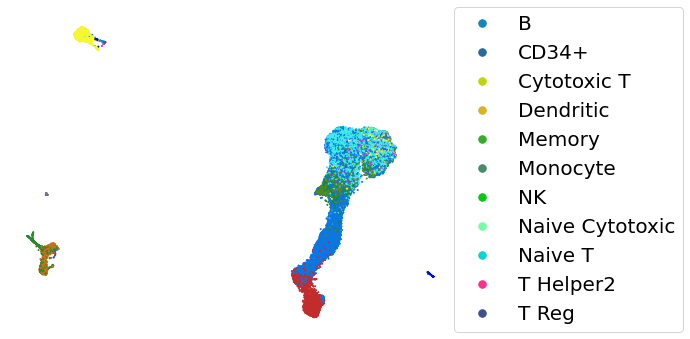

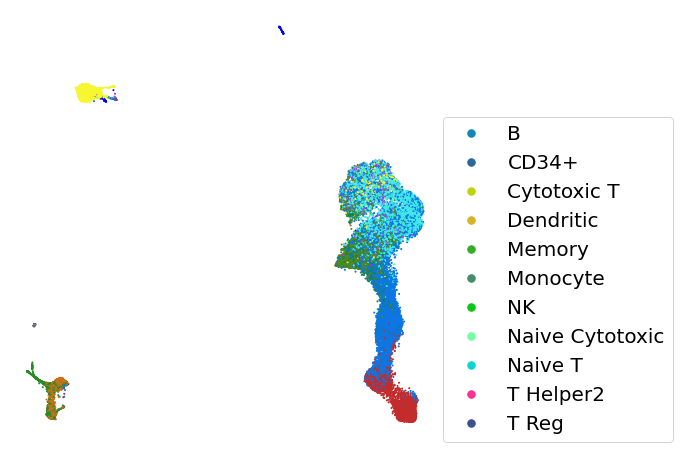

In [38]:
for i in range(repeats):
    plt.figure(figsize=(8,8))
    scatter = plt.scatter(*umappers_pbmc[i].embedding_.T,
                          c=pbmc_labels,
                          s=1.0,
                          cmap=pbmc_cmap)
    # dummy dots for legend
    dots = []
    for i in range(len(np.unique(cell_types))):
        dot = mlines.Line2D([], [], color=colors[i], marker='.', linestyle="none",
                              markersize=15, label=np.unique(cell_types)[i])
        dots.append(dot)
    plt.legend(handles=dots, prop={'size': 20}, loc=(1,0))

    plt.axis("off")
    plt.gca().set_aspect("equal")